# Naive Bayes on Amazon Fine Food Reviews Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, make_scorer, classification_report, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv("all reviews.csv") # reading the csv file
df.sort_values("Time", inplace = True) # sorting the reviews based on time
df.dropna(inplace = True) # dropping all the nan values
df = df[:300000] # taking 3,00,000 reviews into consideration

In [ ]:
train_X, train_Y = df[:210000].Lemmatized, df[:210000].Score # train data
test_X, test_Y = df[210000:].Lemmatized, df[210000:].Score # test data

# Bag Of Words

## Bag of Words with Standardizing the Data

### Vectorizing the reviews

In [ ]:
bow = CountVectorizer(ngram_range = (1,2)).fit(train_X)
train_X = bow.transform(train_X)
bow_std = StandardScaler(with_mean = False).fit(train_X)
train_X = bow_std.transform(train_X)

### Finding the optimal alpha using GridSearchCV
Here I have used recall score of the negative reviews as the scoring parameter. For almost any value of alpha, the recall score and precision of the positive reviews were good but was very low for negative reviews. Hence, I thought of using the recall score of negative reviews as the scoring parameter in GridSearchCV to maximize the model's ability to predict a negative review. In order to implement this, I used make_scorer function from sklearn.metrics class. I defined a function "recall" which will return the recall score of the negative class and this "recall" function is passed as the input to the make_scorer function which is then passed to the GridSearchCV as the scoring parameter.

In [ ]:
# defining the parameters for GridSearchCV
parameters = {"alpha":[.00001,.0001,.001,.01,.1,1,10,100,1000,10000]}

In [77]:
# this function would return the recall score of the negative reviews
def recall(y_true, pred):
    rec = recall_score(y_true, pred, pos_label = "negative")
    return rec

In [78]:
# we need to make use of the make_scorer function to customize our scoring parameters 
sc = make_scorer(recall)

In [79]:
%%time
# finding out the optimal alpha using GridSearchCV
nb = MultinomialNB()
grid_cv = GridSearchCV(estimator = nb, param_grid = parameters, cv = 5, scoring = sc)
grid_cv.fit(train_X, train_Y)

Wall time: 3min 47s


In [80]:
# this would give us the best parameter
grid_cv.best_estimator_

MultinomialNB(alpha=100, class_prior=None, fit_prior=True)

In [81]:
# these are the scores of the every iteration of the given parameters
# scores here are the recall scores of the negative class
grid_cv.grid_scores_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.30679, std: 0.00565, params: {'alpha': 1e-05},
 mean: 0.34188, std: 0.00527, params: {'alpha': 0.0001},
 mean: 0.39103, std: 0.00700, params: {'alpha': 0.001},
 mean: 0.46767, std: 0.00716, params: {'alpha': 0.01},
 mean: 0.58142, std: 0.01232, params: {'alpha': 0.1},
 mean: 0.74335, std: 0.01833, params: {'alpha': 1},
 mean: 0.89985, std: 0.01289, params: {'alpha': 10},
 mean: 0.95122, std: 0.00882, params: {'alpha': 100},
 mean: 0.80404, std: 0.01661, params: {'alpha': 1000},
 mean: 0.28885, std: 0.00798, params: {'alpha': 10000}]

## Testing

In [5]:
# preparing the test data set
test_X = bow.transform(test_X)
test_X = bow_std.transform(test_X)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# a function which would print out TPR, TNR, FPR, FNR 
def rates(true, pred):
    con_mat = confusion_matrix(true, pred, labels = ["positive", "negative"])
    TP = con_mat[0][0]
    TN = con_mat[1][1]
    FP = con_mat[0][1]
    FN = con_mat[1][0]
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    FPR = 1 - TNR
    FNR = 1 - TPR
    print(f'TPR : {TPR}\nTNR : {TNR}\nFPR : {FPR}\nFNR : {FNR}')

Testing on Train Dataset


 Accuracy = 0.9955761904761905

Train Error = 0.0044238095238094965

             precision    recall  f1-score   support

   negative       0.98      0.99      0.98     30154
   positive       1.00      1.00      1.00    179846

avg / total       1.00      1.00      1.00    210000



Testing on Test Dataset


 Accuracy = 0.8541666666666666

Test Error = 0.14583333333333337

             precision    recall  f1-score   support

   negative       0.58      0.62      0.60     15894
   positive       0.92      0.91      0.91     74106

avg / total       0.86      0.85      0.86     90000



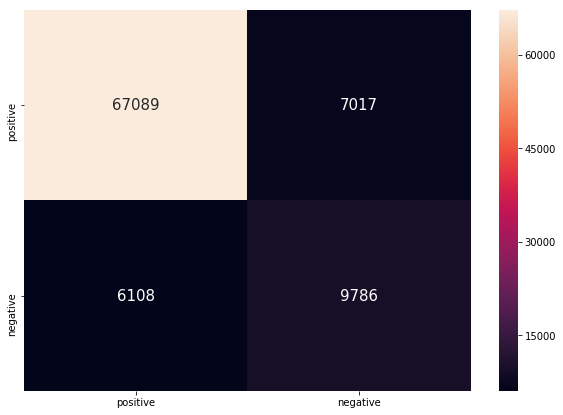

TPR : 0.9165539571293906
TNR : 0.5823960007141582
FPR : 0.4176039992858418
FNR : 0.08344604287060942


In [16]:
nb = MultinomialNB(alpha = 100)
nb.fit(train_X, train_Y)
pred = nb.predict(train_X)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = nb.predict(test_X)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()
rates(test_Y, pred)

## Feature Importance

### Top 20 Positive Words/Features
There are two ways through which we can obtain the top positive reviews. One is through coef_ attribute and the other is feature_log_prob_. I have used both in this case.

In [95]:
w = nb.coef_
w_sort = w.argsort()
w_sort = w_sort[0]
top_20_positive_words = np.take(bow.get_feature_names(), w_sort[:len(w_sort)-21:-1])
print(top_20_positive_words)

['great' 'love' 'good' 'like' 'taste' 'not' 'make' 'find' 'try' 'get'
 'one' 'well' 'use' 'buy' 'flavor' 'best' 'product' 'time' 'really' 'also']


In [96]:
top_20_pos_words = nb.feature_log_prob_[1][:].argsort()
top_20_pos_words = np.take(bow.get_feature_names(), top_20_pos_words[:(len(top_20_pos_words)-21):-1])
print(top_20_pos_words)

['great' 'love' 'good' 'like' 'taste' 'not' 'make' 'find' 'try' 'get'
 'one' 'well' 'use' 'buy' 'flavor' 'best' 'product' 'time' 'really' 'also']


### Top 20 Negative Words/Features

In [97]:
top_20_neg_words = nb.feature_log_prob_[0][:].argsort()
top_20_neg_words = np.take(bow.get_feature_names(), top_20_neg_words[:(len(top_20_neg_words)-21):-1])
print(top_20_neg_words)

['not' 'taste' 'like' 'product' 'buy' 'would' 'disappoint' 'bad' 'think'
 'one' 'get' 'try' 'money' 'again' 'even' 'order' 'dont' 'waste'
 'waste money' 'throw']


## Bag of Words without Standardizing the Data
Everything is the same as above model, the only difference is that the reviews are not Standardized after vectorizing

### Vectorizing

In [17]:
train_X, train_Y = df[:210000].Lemmatized, df[:210000].Score # train data
test_X, test_Y = df[210000:].Lemmatized, df[210000:].Score # test data

bow = CountVectorizer(ngram_range = (1,2)).fit(train_X)
train_X = bow.transform(train_X)

### Finding the Optimal Alpha

In [99]:
%%time
parameters = {"alpha":[.00001,.0001,.001,.01,.1,1,10,100,1000,10000]}
def recall(y_true, pred):
    rec = recall_score(y_true, pred, pos_label = "negative")
    return rec
sc = make_scorer(recall)
nb = MultinomialNB()
grid_cv = GridSearchCV(estimator = nb, param_grid = parameters, cv = 5, scoring = sc)
grid_cv.fit(train_X, train_Y)

Wall time: 3min 49s


In [100]:
grid_cv.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [101]:
grid_cv.grid_scores_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.38356, std: 0.01173, params: {'alpha': 1e-05},
 mean: 0.45878, std: 0.01532, params: {'alpha': 0.0001},
 mean: 0.57210, std: 0.02199, params: {'alpha': 0.001},
 mean: 0.72176, std: 0.02731, params: {'alpha': 0.01},
 mean: 0.83415, std: 0.02359, params: {'alpha': 0.1},
 mean: 0.40472, std: 0.01626, params: {'alpha': 1},
 mean: 0.00030, std: 0.00012, params: {'alpha': 10},
 mean: 0.00000, std: 0.00000, params: {'alpha': 100},
 mean: 0.00000, std: 0.00000, params: {'alpha': 1000},
 mean: 0.00000, std: 0.00000, params: {'alpha': 10000}]

### Testing

In [18]:
test_X, test_Y = df[210000:].Lemmatized, df[210000:].Score # test data
test_X = bow.transform(test_X)

Testing on Train Dataset


 Accuracy = 0.9902142857142857

Train Error = 0.009785714285714286

             precision    recall  f1-score   support

   negative       0.95      0.98      0.97     30154
   positive       1.00      0.99      0.99    179846

avg / total       0.99      0.99      0.99    210000



Testing on Test Dataset


 Accuracy = 0.9189666666666667

Test Error = 0.08103333333333329

             precision    recall  f1-score   support

   negative       0.81      0.70      0.75     15894
   positive       0.94      0.97      0.95     74106

avg / total       0.92      0.92      0.92     90000



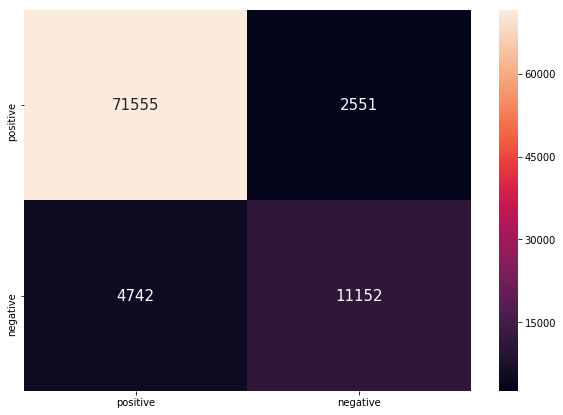

TPR : 0.9378481460607888
TNR : 0.8138363861928045
FPR : 0.18616361380719548
FNR : 0.06215185393921119


In [19]:
nb = MultinomialNB(alpha = .1)
nb.fit(train_X, train_Y)
pred = nb.predict(train_X)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = nb.predict(test_X)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()
rates(test_Y, pred)

In [104]:
top_20_pos_words = nb.feature_log_prob_[1][:].argsort()
top_20_pos_words = np.take(bow.get_feature_names(), top_20_pos_words[:(len(top_20_pos_words)-21):-1])
print(top_20_pos_words)

['not' 'like' 'taste' 'good' 'great' 'love' 'make' 'flavor' 'use' 'one'
 'get' 'tea' 'product' 'try' 'find' 'buy' 'well' 'coffee' 'food' 'eat']


In [105]:
top_20_neg_words = nb.feature_log_prob_[0][:].argsort()
top_20_neg_words = np.take(bow.get_feature_names(), top_20_neg_words[:(len(top_20_neg_words)-21):-1])
print(top_20_neg_words)

['not' 'taste' 'like' 'product' 'buy' 'one' 'get' 'flavor' 'try' 'would'
 'make' 'good' 'coffee' 'use' 'well' 'order' 'food' 'think' 'tea' 'eat']


# TF-IDF

## TF-IDF with Standardizing the Data

### Vectorizing

In [20]:
tfidf = TfidfVectorizer(ngram_range = (1,2))
tfidf.fit(df[:210000].Lemmatized)
train_X_tfidf = tfidf.transform(df[:210000].Lemmatized)
tfidf_std = StandardScaler(with_mean = False).fit(train_X_tfidf)
train_X_tfidf = tfidf_std.transform(train_X_tfidf)
train_Y_tfidf = df.Score[:210000]

### FInding the Optimal Alpha

In [107]:
parameters = {"alpha" : [.00001,.0001,.001,.01,.1,1,10,100,1000,10000]}
def recall(y_true, pred):
    rec = recall_score(y_true, pred, pos_label = "negative")
    return rec
sc = make_scorer(recall)

In [108]:
%%time
nb = MultinomialNB()
grid_cv = GridSearchCV(estimator = nb, param_grid = parameters, cv = 5, scoring = sc)
grid_cv.fit(train_X_tfidf, train_Y_tfidf)

Wall time: 3min 39s


In [109]:
grid_cv.best_estimator_

MultinomialNB(alpha=100, class_prior=None, fit_prior=True)

In [110]:
grid_cv.grid_scores_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.30775, std: 0.00609, params: {'alpha': 1e-05},
 mean: 0.34669, std: 0.00849, params: {'alpha': 0.0001},
 mean: 0.39865, std: 0.00961, params: {'alpha': 0.001},
 mean: 0.47828, std: 0.01281, params: {'alpha': 0.01},
 mean: 0.59163, std: 0.01614, params: {'alpha': 0.1},
 mean: 0.74716, std: 0.02053, params: {'alpha': 1},
 mean: 0.90161, std: 0.01268, params: {'alpha': 10},
 mean: 0.95324, std: 0.00863, params: {'alpha': 100},
 mean: 0.79923, std: 0.01857, params: {'alpha': 1000},
 mean: 0.31886, std: 0.01784, params: {'alpha': 10000}]

## Testing

In [21]:
test_X_tfidf = tfidf.transform(df.Lemmatized[210000:])
test_X_tfidf = tfidf_std.transform(test_X_tfidf)
test_Y_tfidf = df.Score[210000:]

Testing on Train Dataset


 Accuracy = 0.9978952380952381

Train Error = 0.0021047619047619426

             precision    recall  f1-score   support

   negative       0.99      1.00      0.99     30154
   positive       1.00      1.00      1.00    179846

avg / total       1.00      1.00      1.00    210000



Testing on Test Dataset


 Accuracy = 0.8276666666666667

Test Error = 0.17233333333333334

             precision    recall  f1-score   support

   negative       0.51      0.60      0.55     15894
   positive       0.91      0.88      0.89     74106

avg / total       0.84      0.83      0.83     90000



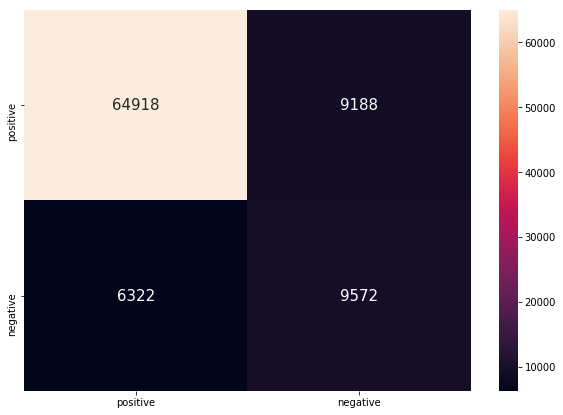

TPR : 0.911257720381808
TNR : 0.5102345415778251
FPR : 0.4897654584221749
FNR : 0.08874227961819203


In [22]:
nb = MultinomialNB(alpha = 100)
nb.fit(train_X_tfidf, train_Y)
pred = nb.predict(train_X_tfidf)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = nb.predict(test_X_tfidf)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()
rates(test_Y, pred)

## Feature Importance

### Top 20 Positive Words/Features

In [119]:
w = nb.coef_
w_sort = w.argsort()

In [120]:
w_sort = w_sort[0]
top_20_positive_words = np.take(tfidf.get_feature_names(), w_sort[:len(w_sort)-21:-1])
print(top_20_positive_words)

['love' 'great' 'like' 'taste' 'not' 'good' 'make' 'use' 'one' 'get'
 'flavor' 'try' 'find' 'well' 'buy' 'product' 'best' 'amazon' 'time' 'eat']


### Top 20 Negative Words/Features

In [121]:
top_20_neg_words = nb.feature_log_prob_[0][:].argsort()
top_20_neg_words = np.take(tfidf.get_feature_names(), top_20_neg_words[:(len(top_20_neg_words)-21):-1])
print(top_20_neg_words)

['not' 'taste' 'like' 'product' 'would' 'buy' 'disappoint' 'bad' 'think'
 'one' 'get' 'try' 'money' 'dont' 'waste' 'even' 'throw' 'return' 'flavor'
 'waste money']


## TF-IDF without Standardizing the Data

### Vectorizing

In [23]:
train_X_tfidf = tfidf.transform(df[:210000].Lemmatized)
train_Y_tfidf = df.Score[:210000]

### Finding the Optimal Alpha

In [123]:
%%time
nb = MultinomialNB()
grid_cv = GridSearchCV(estimator = nb, param_grid = parameters, cv = 5, scoring = sc)
grid_cv.fit(train_X_tfidf, train_Y_tfidf)

Wall time: 3min 40s


In [124]:
grid_cv.best_estimator_

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [125]:
grid_cv.grid_scores_

C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.32543, std: 0.01221, params: {'alpha': 1e-05},
 mean: 0.40744, std: 0.01613, params: {'alpha': 0.0001},
 mean: 0.53883, std: 0.02482, params: {'alpha': 0.001},
 mean: 0.67285, std: 0.03145, params: {'alpha': 0.01},
 mean: 0.33674, std: 0.02276, params: {'alpha': 0.1},
 mean: 0.00010, std: 0.00008, params: {'alpha': 1},
 mean: 0.00000, std: 0.00000, params: {'alpha': 10},
 mean: 0.00000, std: 0.00000, params: {'alpha': 100},
 mean: 0.00000, std: 0.00000, params: {'alpha': 1000},
 mean: 0.00000, std: 0.00000, params: {'alpha': 10000}]

### Testing

In [24]:
test_X_tfidf = tfidf.transform(df.Lemmatized[210000:])
test_Y_tfidf = df.Score[210000:]

Testing on Train Dataset


 Accuracy = 0.9968809523809524

Train Error = 0.003119047619047577

             precision    recall  f1-score   support

   negative       1.00      0.98      0.99     30154
   positive       1.00      1.00      1.00    179846

avg / total       1.00      1.00      1.00    210000



Testing on Test Dataset


 Accuracy = 0.8930555555555556

Test Error = 0.1069444444444444

             precision    recall  f1-score   support

   negative       0.90      0.44      0.59     15894
   positive       0.89      0.99      0.94     74106

avg / total       0.89      0.89      0.88     90000



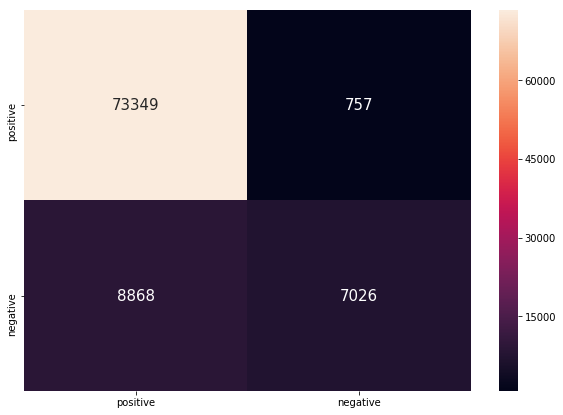

TPR : 0.8921390953209191
TNR : 0.9027367339072337
FPR : 0.09726326609276625
FNR : 0.10786090467908094


In [25]:
nb = MultinomialNB(alpha = .01)
nb.fit(train_X_tfidf, train_Y)
pred = nb.predict(train_X_tfidf)
acc = accuracy_score(train_Y, pred)
report = classification_report(train_Y, pred)
print('\033[1m' + "Testing on Train Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Train Error = {1-acc}\n')
print(report)
print("\n")
pred = nb.predict(test_X_tfidf)
acc = accuracy_score(test_Y, pred)
report = classification_report(test_Y, pred)
con_mat = confusion_matrix(test_Y, pred, labels = ["positive", "negative"])
print('\033[1m' + "Testing on Test Dataset")
print("\033[0m" + "\n")
print(f' Accuracy = {acc}\n')
print(f'Test Error = {1-acc}\n')
print(report)
con_mat_df = pd.DataFrame(data = con_mat, columns = "positive negative".split(), index = "positive negative".split())
plt.figure(figsize = (10,7))
sn.heatmap(con_mat_df, annot_kws = {"size":15},annot=True,fmt="g")
plt.show()
rates(test_Y, pred)

# Conclusion

<table align = "left">  <thead style = "font-size : 15px">            <th style="text-align: center;">Model</th>      <th style="text-align: center;">Alpha</th>      <th style="text-align: center;">Train Error</th>      <th style="text-align: center;">Test Error</th>      <th>f1-score of<br>positive class</th>      <th style="text-align: center;">f1-score of<br>negative class</th>  </thead>  <tbody style="font-size:15px;">    <tr style="text-align: center;">            <td style="text-align: center;">BoW without Standardization</td>      <td style="text-align: center;">0.1</td>      <td style="text-align: center;">0.009785</td>      <td style="text-align: center;">0.081033</td>      <td style="text-align: center;">0.95</td>      <td style="text-align: center;">0.75</td>    </tr>    <tr>            <td style="text-align: center;">BoW with Standardization</td>      <td style="text-align: center;">100</td>      <td style="text-align: center;">0.004423</td>      <td style="text-align: center;">0.145833</td>      <td style="text-align: center;">0.91</td>      <td style="text-align: center;">0.60</td>    </tr>    <tr>          <td style="text-align: center;">TF-IDF without Standardization</td>      <td style="text-align: center;">0.01</td>      <td style="text-align: center;">0.003119</td>      <td style="text-align: center;">0.106944</td>      <td style="text-align: center;">0.94</td>      <td style="text-align: center;">0.59</td>    </tr>    <tr>           <td style="text-align: center;">TF-IDF with Standardization</td>      <td style="text-align: center;">100</td>      <td style="text-align: center;">0.002105</td>      <td style="text-align: center;">0.172333</td>      <td style="text-align: center;">0.89</td>      <td style="text-align: center;">0.55</td>    </tr>  </tbody></table>

<br>
<p style = "font-size: 18px;"> As we can see, <b>Bag of Words without Standardization </b>performed the best </p>